In [1]:
import pandas as pd
from os.path import dirname, realpath, join, isfile
from utils import get_ps1_or_ipaddress, read_pcap_fields_from_txts, download_roku_channel_details, ROKU_MACS

In [2]:
import seaborn as sns
%matplotlib inline
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(16,9)})

In [3]:
ROOT_PROJ_DIR = dirname(dirname(dirname(dirname(realpath('__file__')))))
DATA_DIR = join(ROOT_PROJ_DIR, "data/pcap_analysis/roku-channel-surfer/2018-09-27")
HTTP_REQS_DIR = join(DATA_DIR, "http")
DNS_QUERIES_DIR = join(DATA_DIR, "dns")
TLS_SNI_DIR = join(DATA_DIR, "tls_sni")
HTTP_CSV = join(DATA_DIR, "roku-2018-09-27-requests.csv")
DNS_CSV = join(DATA_DIR, "roku-2018-09-27-dns.csv")
TLS_SNI_CSV = join(DATA_DIR, "roku-2018-09-27-tls-sni.csv")

### Load channel details
- We only channels details to add helper columns to request dataframe
- Once we build and store the request details, we don't actually need to do this

In [4]:
channel_df = download_roku_channel_details()

## Load TLS connection details
- Load the DNS details from the CSV or build from scratch
- The command used to generate the txt files from pcaps:

```./extract_fields.sh -i /media/gacar/Data/dev/smart-data/pcaps/ -f ssl.handshake.extensions_server_name -e eth.src -e ip.dst -e ssl.handshake.extensions_server_name```

In [5]:
if isfile(TLS_SNI_CSV):
    # load from csv if we already built the dataframe
    df = pd.read_csv(TLS_SNI_CSV, sep='\t', encoding='utf-8')
else:
    # we use `extract_fields.sh` script to extract the following
    # eth.src, ip.dst, ssl.handshake.extensions_server_name
    # here we read the extracted fields into a dataframe
    all_sni_fields = [sni_fields for sni_fields in read_pcap_fields_from_txts(TLS_SNI_DIR)]
    df = pd.DataFrame(all_sni_fields, columns=['channel_id', 'start_ts', 'command', 'select_idx', 'eth_src', 'ip_dst', 'host'])
    # exclude packets from other devices
    df = df[df.eth_src.isin(ROKU_MACS)]
    df['channel_name'] = df['channel_id'].map(lambda x: channel_df.loc[int(x)]['name'])
    df['rank'] = df['channel_id'].map(lambda x: channel_df.loc[int(x)]['rankByWatched'])
    df['category'] = df['channel_id'].map(lambda x: channel_df.loc[int(x)]['_category'])
    df['domain'] = df['host'].map(lambda x: get_ps1_or_ipaddress("http://" + x))
    df.to_csv(TLS_SNI_CSV, index=False, sep='\t', encoding='utf-8')
    

In [6]:
df.head()

,channel_id,start_ts,command,select_idx,eth_src,ip_dst,host,channel_name,rank,category,domain
0,145651,1538303764,launch,0,d8:31:34:22:e6:ff,52.45.134.131,api.roku.com,BIO TV,2068,movies-tvs,roku.com
1,145651,1538303764,launch,0,d8:31:34:22:e6:ff,52.84.122.195,wwwimg.roku.com,BIO TV,2068,movies-tvs,roku.com
2,145651,1538303764,launch,0,d8:31:34:22:e6:ff,52.21.59.215,api.sr.roku.com,BIO TV,2068,movies-tvs,roku.com
3,145651,1538303764,launch,0,d8:31:34:22:e6:ff,52.84.122.175,cigars.roku.com,BIO TV,2068,movies-tvs,roku.com
4,145651,1538303764,launch,0,d8:31:34:22:e6:ff,52.84.122.179,cigars.roku.com,BIO TV,2068,movies-tvs,roku.com


### TLS connections - overview

In [7]:
print "%d TLS connections to %d distinct domains from %s distinct channels" %\
    (len(df), df.domain.nunique(), df.channel_id.nunique())

11185 TLS connections to 485 distinct domains from 1406 distinct channels


### Top domains
- domains contacted by most channels

In [8]:
df.drop_duplicates(subset=["channel_id", "domain"]).\
    groupby(["domain"]).size().reset_index(name="# channels").\
    sort_values(by=['# channels'], ascending=False).head(10)

,domain,# channels
336,roku.com,1186
449,vimeo.com,163
130,doubleclick.net,161
195,ifood.tv,161
172,google-analytics.com,141
450,vimeocdn.com,118
45,archive.org,91
349,scorecardresearch.com,89
49,att.net,84
29,akamaized.net,82


In [9]:
df[df.domain=="att.net"].head()

,channel_id,start_ts,command,select_idx,eth_src,ip_dst,host,channel_name,rank,category,domain
36,85830,1538389118,select,2,d8:31:34:22:e6:ff,144.160.127.24,tprodsmsx.att.net,MarkWHO42,7132,movies-tvs,att.net
269,134321,1538384710,select,2,d8:31:34:22:e6:ff,144.160.225.152,tprodsmsx.att.net,FLIXXNOW,6771,movies-tvs,att.net
283,122651,1538395918,select,1,d8:31:34:22:e6:ff,144.160.147.49,tprodsmsx.att.net,Usilk,7796,movies-tvs,att.net
397,94581,1538385463,select,1,d8:31:34:22:e6:ff,144.160.225.152,tprodsmsx.att.net,FontellWave,6779,movies-tvs,att.net
477,20660,1538398312,select,2,d8:31:34:22:e6:ff,144.160.147.49,tprodsmsx.att.net,iflixtv Lite,6949,movies-tvs,att.net


### Top domains - Kids and family channels

In [10]:
df[df.category == "kids-family"].drop_duplicates(subset=["channel_id", "domain"]).\
    groupby(["domain"]).size().reset_index(name="# channels").\
    sort_values(by=['# channels'], ascending=False).head(10)

,domain,# channels
76,roku.com,389
41,ifood.tv,125
26,doubleclick.net,62
72,ravm.tv,28
93,superawesome.tv,27
90,spotxchange.com,26
109,vimeo.com,24
81,scorecardresearch.com,24
42,imrworldwide.com,21
27,doubleverify.com,21


### Channels talking to most domains over TLS

In [11]:
df_n_domains_by_channel = df.drop_duplicates(subset=["channel_name", "domain", "rank"]).\
    groupby(["channel_name", "rank"]).size().reset_index(name="# domains").\
    sort_values(by=['# domains'], ascending=False)
df_n_domains_by_channel.head(10)

,channel_name,rank,# domains
60,American Cowboy Classics,2267,56
7,8ctave HD,936,22
1035,Shout Factory TV,258,21
86,B-Movie TV,233,19
1249,Trashy Movies Channel,2034,18
818,Movee4U Free,680,17
1098,Superman 3D,1708,17
195,Cartoon Club LIVE,1570,17
1175,The Killer Movie Channel,664,17
277,Comedy Classics,1492,17


### Kids and family channels talking to most domains over TLS

In [12]:
df_n_domains_by_kids_channel = df[df.category == "kids-family"].drop_duplicates(subset=["channel_name", "domain", "rank"]).\
    groupby(["channel_name", "rank"]).size().reset_index(name="# domains").\
    sort_values(by=['# domains'], ascending=False)
df_n_domains_by_kids_channel.head(10)

,channel_name,rank,# domains
333,Superman 3D,1708,17
55,Cartoon Club LIVE,1570,17
376,Toontime TV,1641,15
38,Blossom,3085,15
279,Only Animation TV,3207,14
11,Andrews Toy Channel,3831,13
26,BabyFirst Español,1834,13
318,So Yummy,2637,12
299,Popcornflix Kids,268,12
74,Cocoro,798,11


### Effect of popularity (rank)
- Do popular channels resolve more domains?

/usr/local/lib/python2.7/dist-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


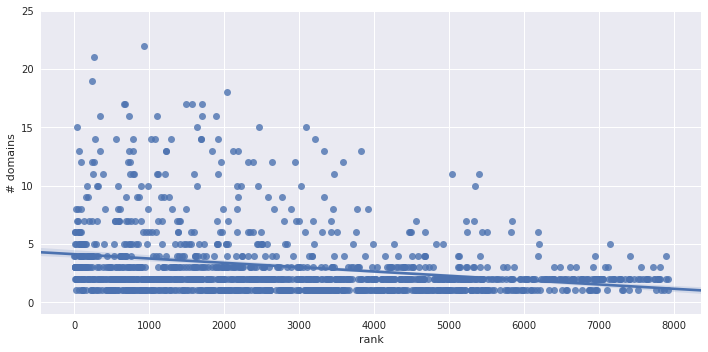

In [13]:
ax = sns.lmplot(x="rank", y="# domains", data=df_n_domains_by_channel, size=5, aspect=2)
ax.set(ylim=(-1, 25))

### Effect of popularity (rank) - Kids and family channels

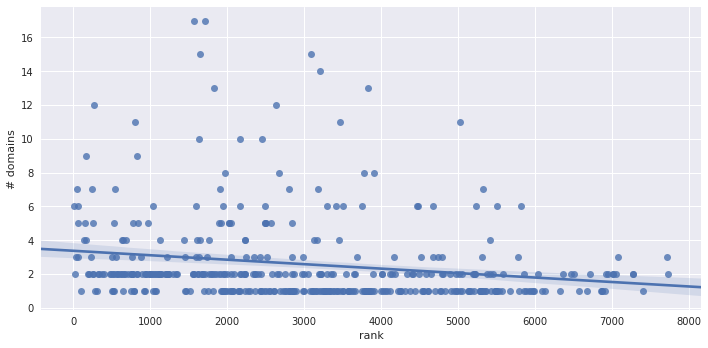

In [14]:
sns.lmplot(x="rank", y="# domains", data=df_n_domains_by_kids_channel, size=5, aspect=2)